In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


## Questions

In [2]:
# set up Kalman filter on your own

#### Recursive equations
How to write the recursive equation for the GCN file correctly? For example the Costas book suggests:

$$ 0 = \mathbb{E}_t \{ \sum_{s=0}^{\infty} (\beta \theta)^s [(1-\psi) Y_{t+s} (\frac{P_{t+s}}{P_t^*})^\psi - Y_{t+s}) (\frac{P_{t+s}}{P_t^*})^\psi mc_{t+s} ]\} $$

$$ LHS_t = (\psi - 1) \{Y_t + \beta \theta \mathbb{E}_t [\sum_{s=0}^{\infty} (\beta \theta)^s Y_{t+s+1} ]\} = (\psi - 1) \{Y_t + \beta \theta \mathbb{E}_t [LHS_{t+1}]$$

$$ RHS_t = \psi P_t^{* -\psi} \{Y_t mc_t + \beta \theta \mathbb{E}_t [\sum_{s=0}^{\infty} (\beta \theta)^s Y_{t+s+1} mc_{t+s+1}]\} = \psi P_t^{* -\psi} \{Y_t mc_t + \beta \theta \mathbb{E}_t [RHS_{t+1}] $$

This does not inlcude the stochastic discount factor, is this problematic?

Instead we derived this in class:

$$ LHS_t = \frac{\psi}{(\psi - 1) P_t^*} RHS_t $$

$$ LHS_t = \lambda_t^{-1} \{ \lambda_t Y_t + \beta \theta \mathbb{E}_t[ sum_{s=0}^{\infty} (\beta \theta)^s Y_{t+s+1} \lambda_{t+s+1} ] \} = \lambda_t Y_t + \beta \theta \mathbb{E}_t[LHS_{t+1}]$$

$$ RHS_t = \lambda_t^{-1} \{ \lambda_t Y_t mc_t + \beta \theta \mathbb{E}_t[ sum_{s=0}^{\infty} (\beta \theta)^s Y_{t+s+1} \lambda_{t+s+1} mc_{t+s+1} ] \} = \lambda_t Y_t mc_t + \beta \theta \mathbb{E}_t[RHS_{t+1}] $$

You have used inflation indexing, in class we derived optimal price setting, is there and advantage to either method, e.g model convergence?

### Variables
Negative overall utility, is this because the code reverses U[] and then minises?

#### Policy matrix
The policy matrix is derived from a markov chain defined by the state space equation. As such it serves as the transition matrix, that is then fed to the Kalman Filter. How is it approximated?

#### Kalman Filter
The Kalaman Filter uses a linear state space equation, with $\bf F$ being the transition matrix, $\bf B u$ being "steering instruction" and thus not applicable?

State variables $\pi_t$, $Y_t$, $C_t$ are the systems main variables. Are jumper variables fed as "hidden" variables similar to velocity with their respective equation describing their law of motion?

The policy matrix corresponds to the transition matrix $\bf F$

The $\bf H$ matrix is the measurement matrix, translating hidden variables into measurement space. In terms of what measurement is the model described? To what degree do we trust Y?

The $\bf R$ matrix is the measurement variance, covariance matrix. How much do sensors vary, and if so do they vary systematically together? Is this what we are using the priors on our noise for, if no priors how is the variance and distribution determined?

How is the state space defined if we only use measurements of one state variable e.g. $Y_t$?

Does the prediction of the Kalman filter one period ahead, just correspond to running the predict step without the update step? Thus we are essentially broadening our believe if performed across several periods.

#### Kalman Filter Code
Why are we doing MLE before the Kalman filter, how are these interlinked?

What library are you using, statsmodel?

### The economics of things
How to incorporate Y-Gap, just as "Y_gap[] = Y[ss] - Y[] ;", then put into Kalman filter

Incorporating energy prices as shock on TC[], then modell shock according to real price change. Use oil and electricity price data for this?

In [3]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results

import numpy as np
import pandas as pd

import os

from config import plt_config
plt.rcParams.update(plt_config)

load model

In [4]:
# extensive vs. intensive margin for labour - participation is more likley

In [5]:
from config import mod5_params
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod7_nk.gcn'), verbose=True)
plot_vars = ['Y', 'C', 'L', 'w', 'r', 'pi']

Model Building Complete.
Found:
	24 equations
	24 variables
	The following "variables" were defined as constants and have been substituted away:
		B_t
	4 stochastic shocks
		 0 / 4 has a defined prior. 
	17 parameters
		 0 / 17 has a defined prior. 
	2 calibrating equations
	2 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [33]:
mod.variables

[C_t,
 Div_t,
 I_t,
 K_t,
 LHS_t,
 LHS_w_t,
 L_t,
 RHS_t,
 RHS_w_t,
 TC_t,
 U_t,
 Y_t,
 lambda_t,
 mc_t,
 pi_obj_t,
 pi_star_t,
 pi_t,
 q_t,
 r_G_t,
 r_t,
 shock_preference_t,
 shock_technology_t,
 w_star_t,
 w_t]

In [34]:
# assign parameters
# mod.free_param_dict.update(mod5_params)
mod.free_param_dict

{'alpha': 0.35,
 'beta': 0.99,
 'delta': 0.025,
 'eta_p': 0.75,
 'eta_w': 0.75,
 'gamma_I': 10.0,
 'gamma_R': 0.9,
 'gamma_Y': 0.05,
 'gamma_pi': 1.5,
 'phi_H': 0.5,
 'psi_p': 0.6,
 'psi_w': 0.782,
 'rho_pi_dot': 0.924,
 'rho_preference': 0.95,
 'rho_technology': 0.95,
 'sigma_C': 2.0,
 'sigma_L': 1.5}

In [35]:
# mod.steady_state_relationships['w_ss']

Investigate priors

Solve

In [36]:
%time mod.steady_state()

Steady state found! Sum of squared residuals is 1.3485582662688972e-25
CPU times: total: 906 ms
Wall time: 1.24 s


In [37]:
# steady state values
mod.print_steady_state()

C_ss                         1.506
Div_ss                       0.669
I_ss                         0.278
K_ss                        11.119
LHS_ss                       6.169
LHS_w_ss                     1.406
L_ss                         0.666
RHS_ss                       3.856
RHS_w_ss                     1.406
TC_ss                       -1.115
U_ss                      -147.270
Y_ss                         1.784
lambda_ss                    0.890
mc_ss                        0.625
pi_obj_ss                    1.000
pi_ss                        1.000
pi_star_ss                   1.000
q_ss                         0.890
r_G_ss                       1.010
r_ss                         0.035
shock_preference_ss          1.000
shock_technology_ss          1.000
w_ss                         1.088
w_star_ss                    1.088


In addition, the following parameter values were calibrated:
phi_pi                      -0.000
phi_pi_obj                   1.000


In [38]:
mod.solve_model(solver="cycle_reduction")

Solution found, sum of squared residuals:  2.099219108031363e-28
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [39]:
mod.check_bk_condition()
;

Model solution has 14 eigenvalues greater than one in modulus and 11 forward-looking variables.
Blanchard-Kahn condition is satisfied.


''

In [40]:
# policy matrix
for name, policy_matrix in zip(["T", "R"], [round(mod.T, 5), round(mod.R, 5)]):
    print(name.center(10).center(50, "="))
    print(policy_matrix.to_string())

====================    T     ====================
                        C  Div        I        K    L  LHS  LHS_w  RHS  RHS_w   TC    U        Y  lambda   mc   pi   pi_obj  pi_star    q    r      r_G  shock_preference  shock_technology        w  w_star
C                 0.48921  0.0  0.00127  0.13710  0.0  0.0    0.0  0.0    0.0  0.0  0.0  0.00731     0.0  0.0  0.0  0.56945      0.0  0.0  0.0 -1.31535           0.11621           0.27953 -0.06906     0.0
Div               0.04635 -0.0  0.00866  0.74229 -0.0 -0.0   -0.0 -0.0   -0.0 -0.0 -0.0 -0.00135    -0.0 -0.0 -0.0 -0.12835     -0.0 -0.0 -0.0  0.24357          -0.01965           2.05512 -1.19789    -0.0
I                -0.01297  0.0  0.89382 -0.07072  0.0  0.0    0.0  0.0    0.0  0.0  0.0  0.00919     0.0  0.0  0.0  0.77345      0.0  0.0  0.0 -1.65448          -0.08422           0.37355 -0.11036     0.0
K                -0.00032 -0.0  0.02235  0.97323 -0.0 -0.0   -0.0 -0.0   -0.0 -0.0 -0.0  0.00023    -0.0 -0.0 -0.0  0.01934     -

Model stats

''

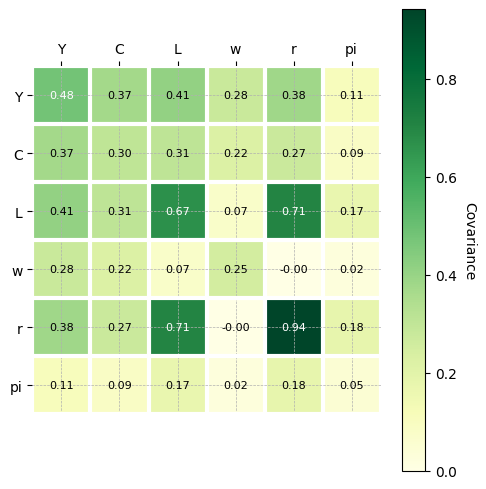

In [41]:
scov = mod.compute_stationary_covariance_matrix()
gp.plot_covariance_matrix(scov, plot_vars,
                          figsize=(5,5))
;

''

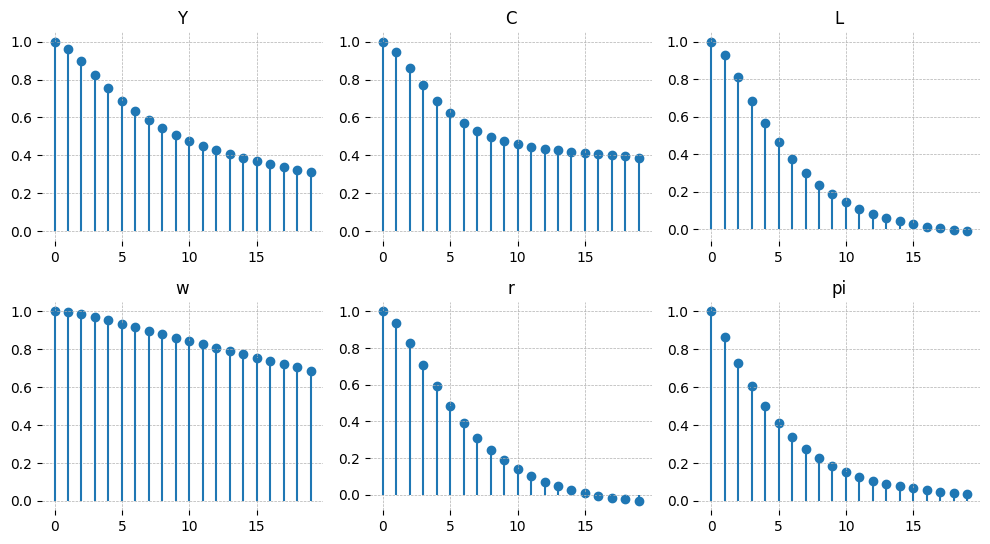

In [42]:
acorr = mod.compute_autocorrelation_matrix(n_lags=20)
gp.plot_acf(acorr, plot_vars, n_cols=3, figsize=(10, 8))
;

IRF

In [43]:
irf = mod.impulse_response_function(simulation_length=60, shock_size=.1)
print(f'Shocks are: {list(set([item[1] for item in irf.unstack().index]))}')
_irf = irf.copy().unstack().loc[:, "epsilon_R"].unstack()

Shocks are: ['epsilon_preference', 'epsilon_pi', 'epsilon_Y', 'epsilon_R']


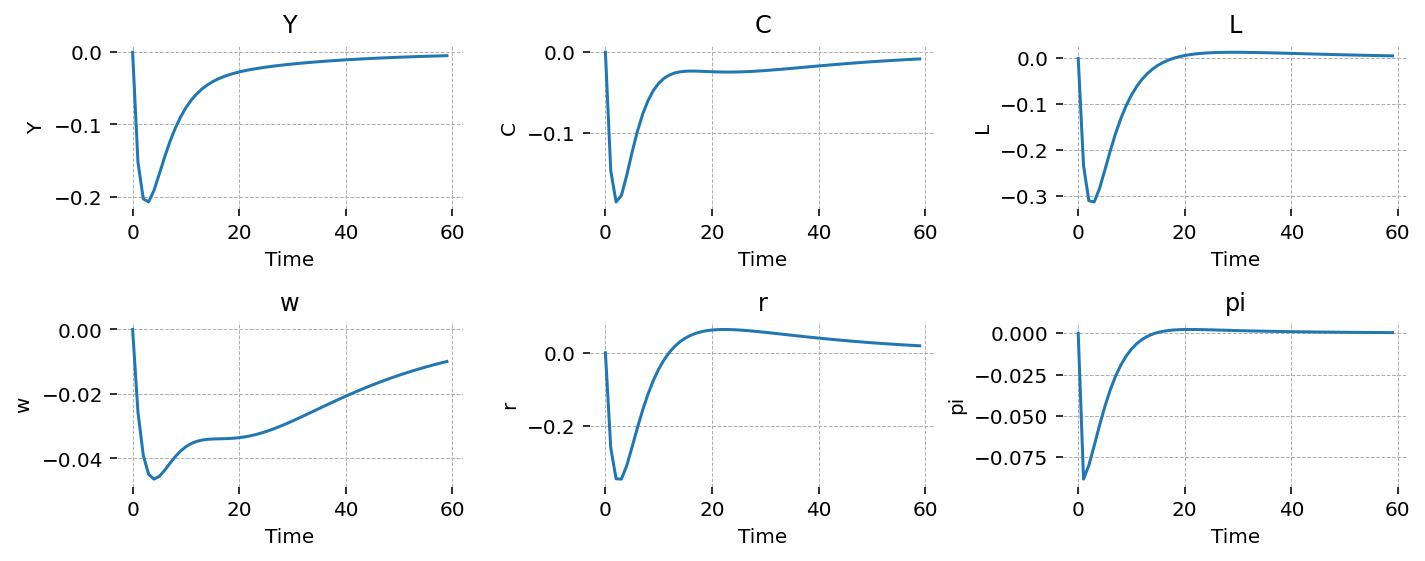

In [44]:
plot_dfs(_irf[plot_vars], sns.lineplot, figsize=(10, 2))

In [ ]:
# package xarrays
# metropolis hastings algortihm - sample from posterior

In [ ]:
# param prior - beta min = 0, max = 1, beta dist
# gamma for sigmas and alpha

# draw from prior 
# free_param_dict.update_priors